# scVI-tools (single-cell variational inference tools)
[공식 문서](https://docs.scvi-tools.org/en/stable/user_guide/index.html)

In [1]:
import scanpy as sc
import scvi
from matplotlib import rcParams

# Load data

In [2]:
# folder_path = "C:/Users/heung/OneDrive/Documents/scData/16. Siglec-9_GSE235913/sc/"
folder_path = "C:/Users/heung/OneDrive/Documents/scData/16. Siglec-9_GSE235913/sc2/"
adata = sc.read(folder_path + "adata_preprocessed.h5ad")
adata

AnnData object with n_obs × n_vars = 150662 × 29566
    obs: 'sample', 'n_genes', 'total_counts', 'pct_counts_mito', 'pct_counts_ribo'
    var: 'n_cells'
    layers: 'counts'

In [3]:
adata.obs.groupby(['sample']).count().n_genes
# adata.obs.groupby(['condition']).count()

C:\Users\heung\AppData\Local\Temp\ipykernel_41328\3723676480.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby(['sample']).count().n_genes


sample
SF10099       458
SF10432       806
SF10857      2122
SF11082      3350
SF11344      4660
             ... 
SF12594      3264
SF12774      2899
SF9791       1296
SF6118v2      396
SF12704v2    3383
Name: n_genes, Length: 70, dtype: int64

# batch 확인

In [4]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

# run time: 2m 19s

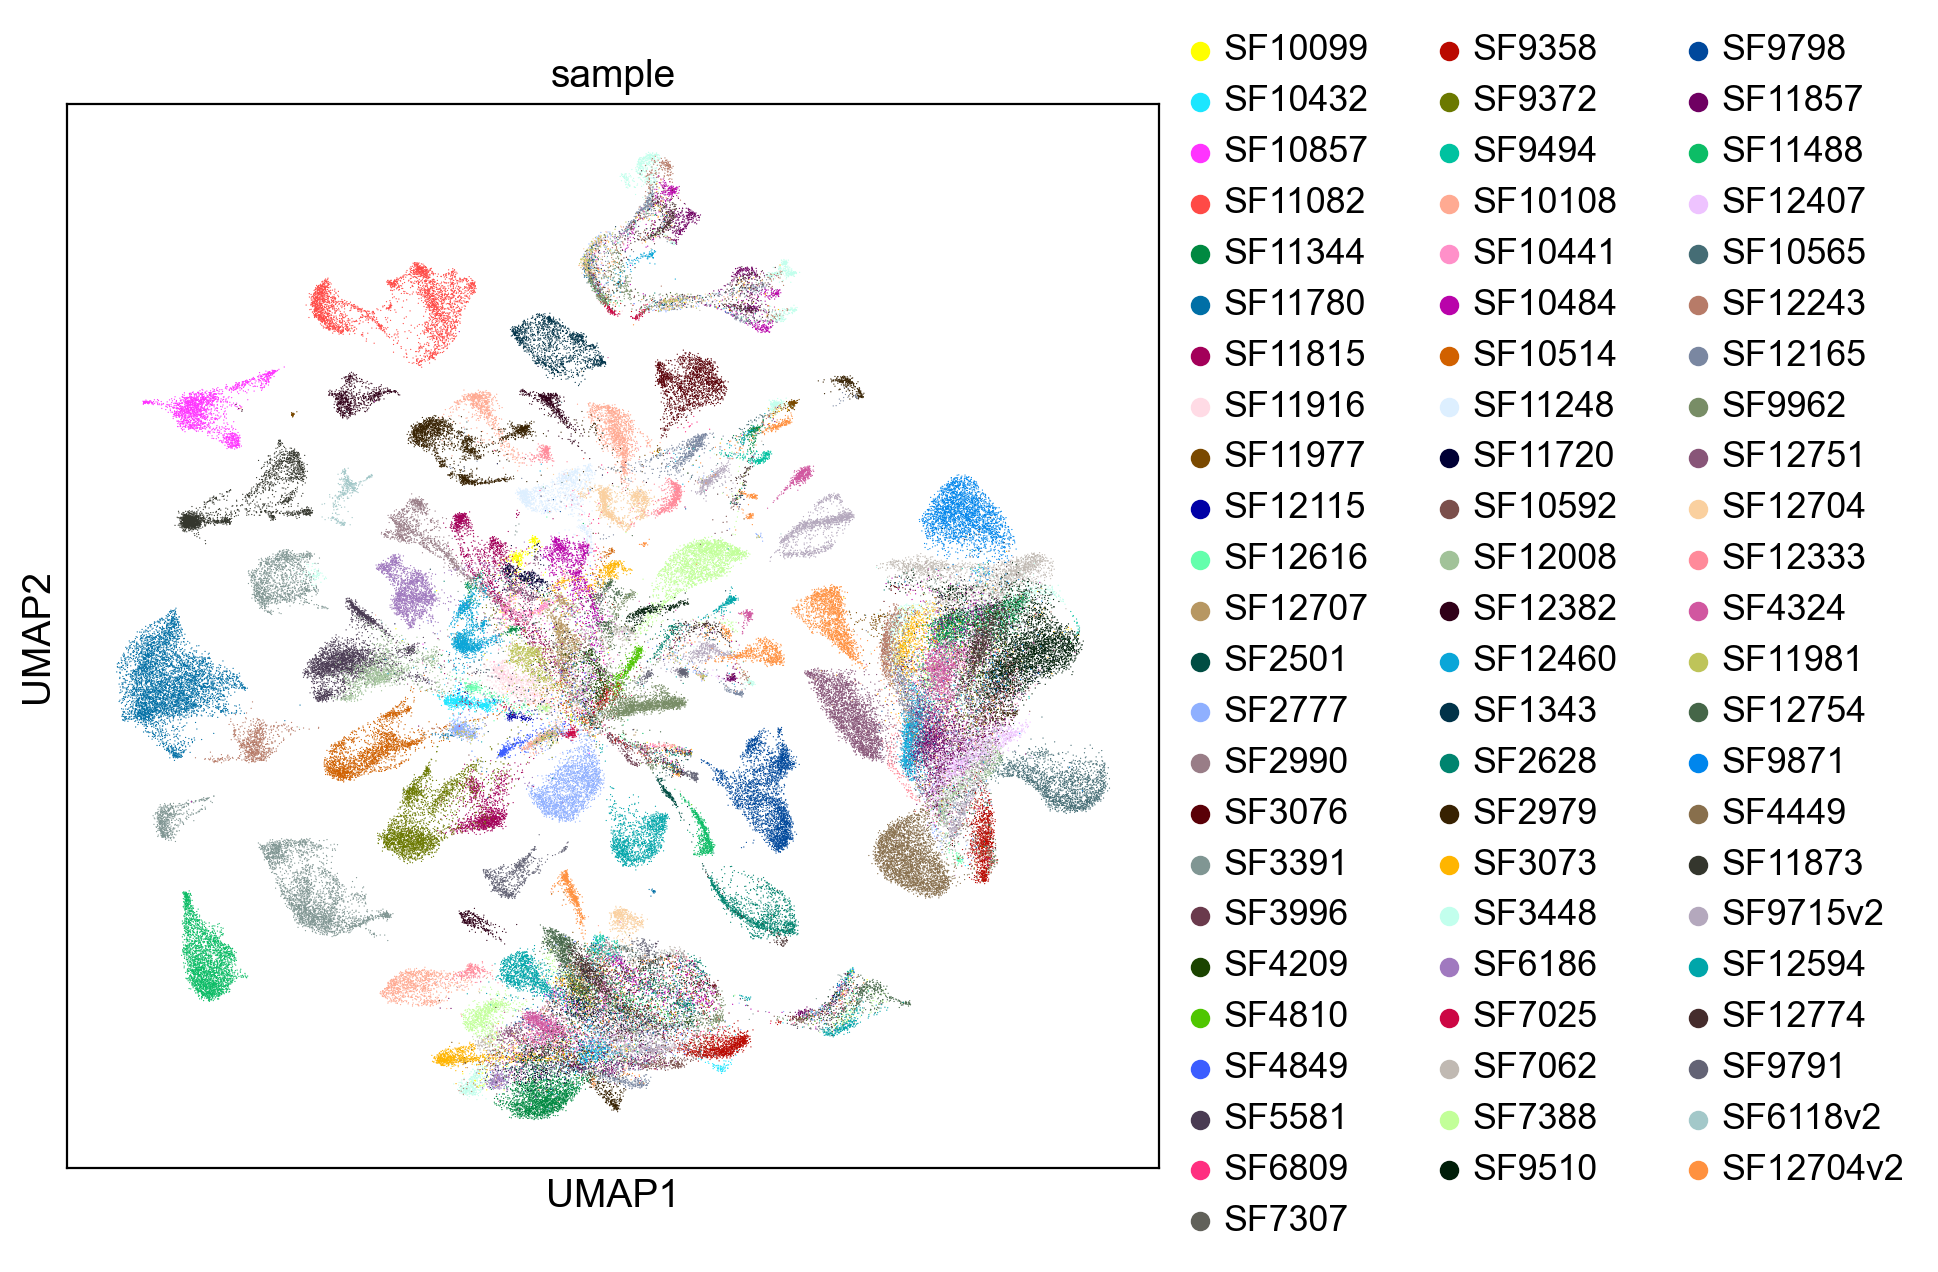

In [5]:
sc.settings.set_figure_params(dpi=100, figsize = (7, 7))
sc.pl.umap(
    adata,
    color = 'sample',
)

# Batch effect correction by scVI

In [ ]:
# pick the top 3000 highly variable genes
# you can pick more if you had more cells
# 3000 genes in 10000 cells is a good number
# gene 개수가 cell 개수의 절반은 되야 한다는 카더라가 있음
# **나는 안돌림**
sc.pp.highly_variable_genes(adata, n_top_genes = 3000, subset = True, layer = 'counts',
                            flavor = 'seurat_v3', batch_key = 'sample')

In [6]:
# making the scVI model
# GPU 안쓰면 개느림. Cuda <- 필수

scvi.model.SCVI.setup_anndata(
    adata,
    layer = 'counts',
    continuous_covariate_keys = ['pct_counts_mito', 'pct_counts_ribo', 'total_counts'],
    batch_key = 'sample'
)
model = scvi.model.SCVI(
    adata,
    n_layers = 4,
    n_latent = 60,
    gene_likelihood = 'nb',
)

c:\Users\heung\anaconda3\Lib\site-packages\scvi\data\fields\_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [7]:
# model.train(max_epochs = 200)
model.train(max_epochs = 100)   # 28m

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\heung\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 100/100: 100%|██████████| 100/100 [25:09<00:00, 15.10s/it, v_num=1, train_loss_step=5.59e+3, train_loss_epoch=5.47e+3]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [25:09<00:00, 15.10s/it, v_num=1, train_loss_step=5.59e+3, train_loss_epoch=5.47e+3]


In [8]:
# get the latent space
adata.obsm['X_scVI'] = model.get_latent_representation()
# model.get_latent_representation().shape
# 7.3GB (크게 차이 없음)

# get scVI normalized data
adata.layers['scvi_normalized'] = model.get_normalized_expression() # <- 용량 큼 (~30GB)

# running time: 5m 25s for 94 samples

In [9]:
# data type 확인
# adata.layers['counts']
adata.layers['scvi_normalized']

array([[5.2628543e-08, 8.8325969e-06, 2.5156890e-08, ..., 7.6169704e-06,
        3.8937549e-07, 1.3721240e-05],
       [5.2442932e-08, 8.0070322e-06, 2.6253005e-08, ..., 8.3476325e-06,
        3.3183539e-07, 1.3420263e-05],
       [6.9465926e-08, 4.1690769e-06, 2.5696318e-08, ..., 1.0936523e-05,
        5.5760967e-07, 2.6400374e-05],
       ...,
       [5.5409227e-08, 2.1070864e-06, 1.8601675e-08, ..., 5.9674535e-06,
        8.0945377e-08, 1.1080309e-05],
       [4.3118558e-08, 3.8133528e-06, 3.8545764e-08, ..., 7.6351089e-06,
        7.4347945e-08, 1.7306369e-05],
       [4.6185626e-08, 4.1516973e-06, 2.0857497e-08, ..., 5.7178763e-06,
        8.5301913e-08, 1.2738641e-05]], dtype=float32)

# Batch regression 확인

In [10]:
# 기본적인 clustering
# sc.pp.pca(adata)
sc.pp.neighbors(adata, use_rep = 'X_scVI')
sc.tl.umap(adata)

# running time: 1m 51s
# running time: 2m 23s for 94 samples

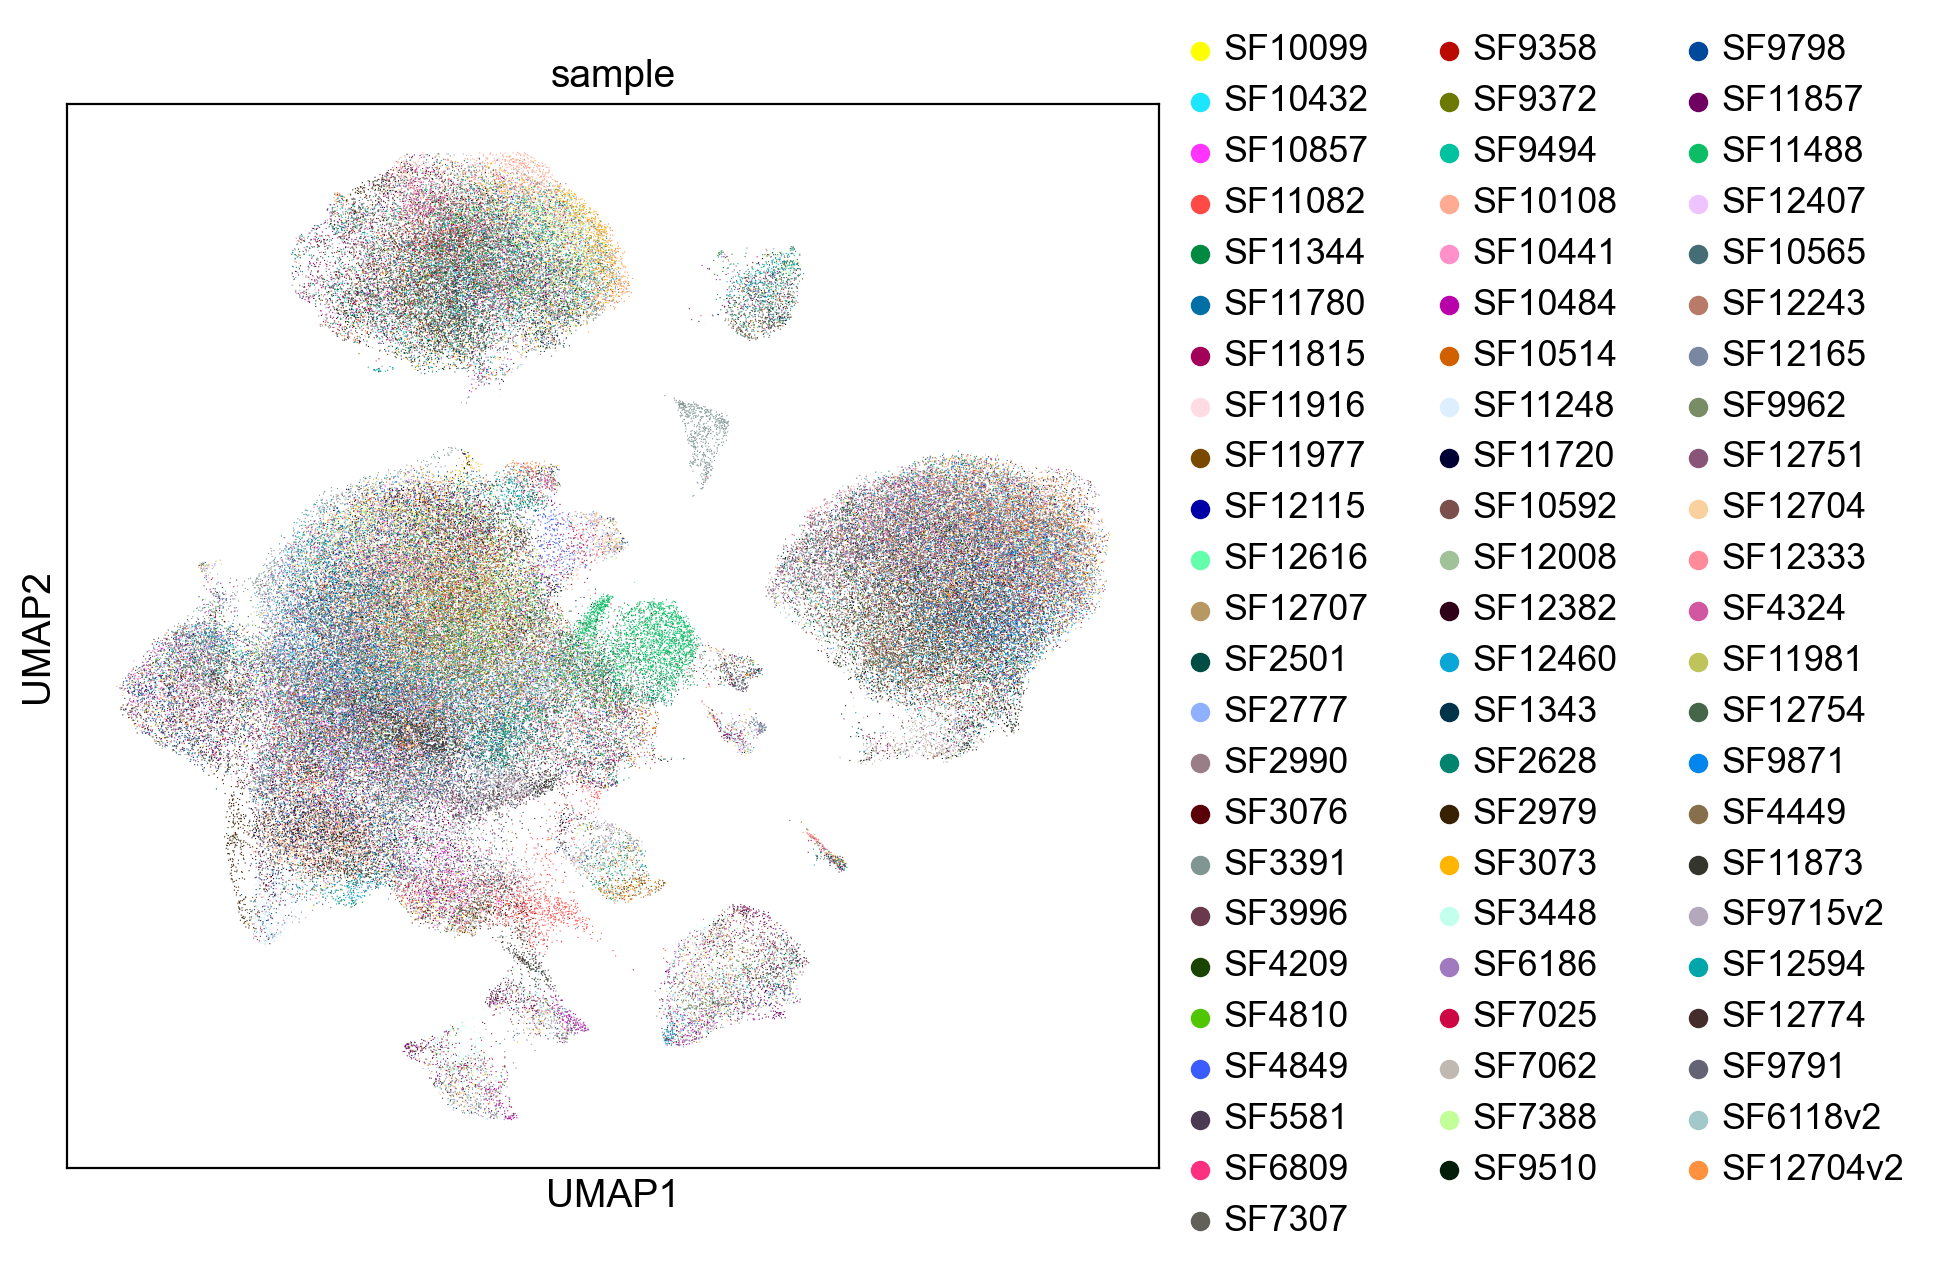

In [11]:
sc.settings.set_figure_params(dpi=100, figsize = (7, 7))

sc.pl.umap(
    adata,
    color = ['sample'],
)

In [17]:
# Clustering
sc.tl.leiden(adata, resolution=1)

# run time: 1m 46s for 94 samples scVI

In [18]:
adata

AnnData object with n_obs × n_vars = 150662 × 29566
    obs: 'sample', 'n_genes', 'total_counts', 'pct_counts_mito', 'pct_counts_ribo', '_scvi_batch', '_scvi_labels', 'leiden'
    var: 'n_cells'
    uns: 'pca', 'neighbors', 'umap', 'sample_colors', '_scvi_uuid', '_scvi_manager_uuid', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap', '_scvi_extra_continuous_covs', 'X_scVI'
    varm: 'PCs'
    layers: 'counts', 'scvi_normalized'
    obsp: 'distances', 'connectivities'

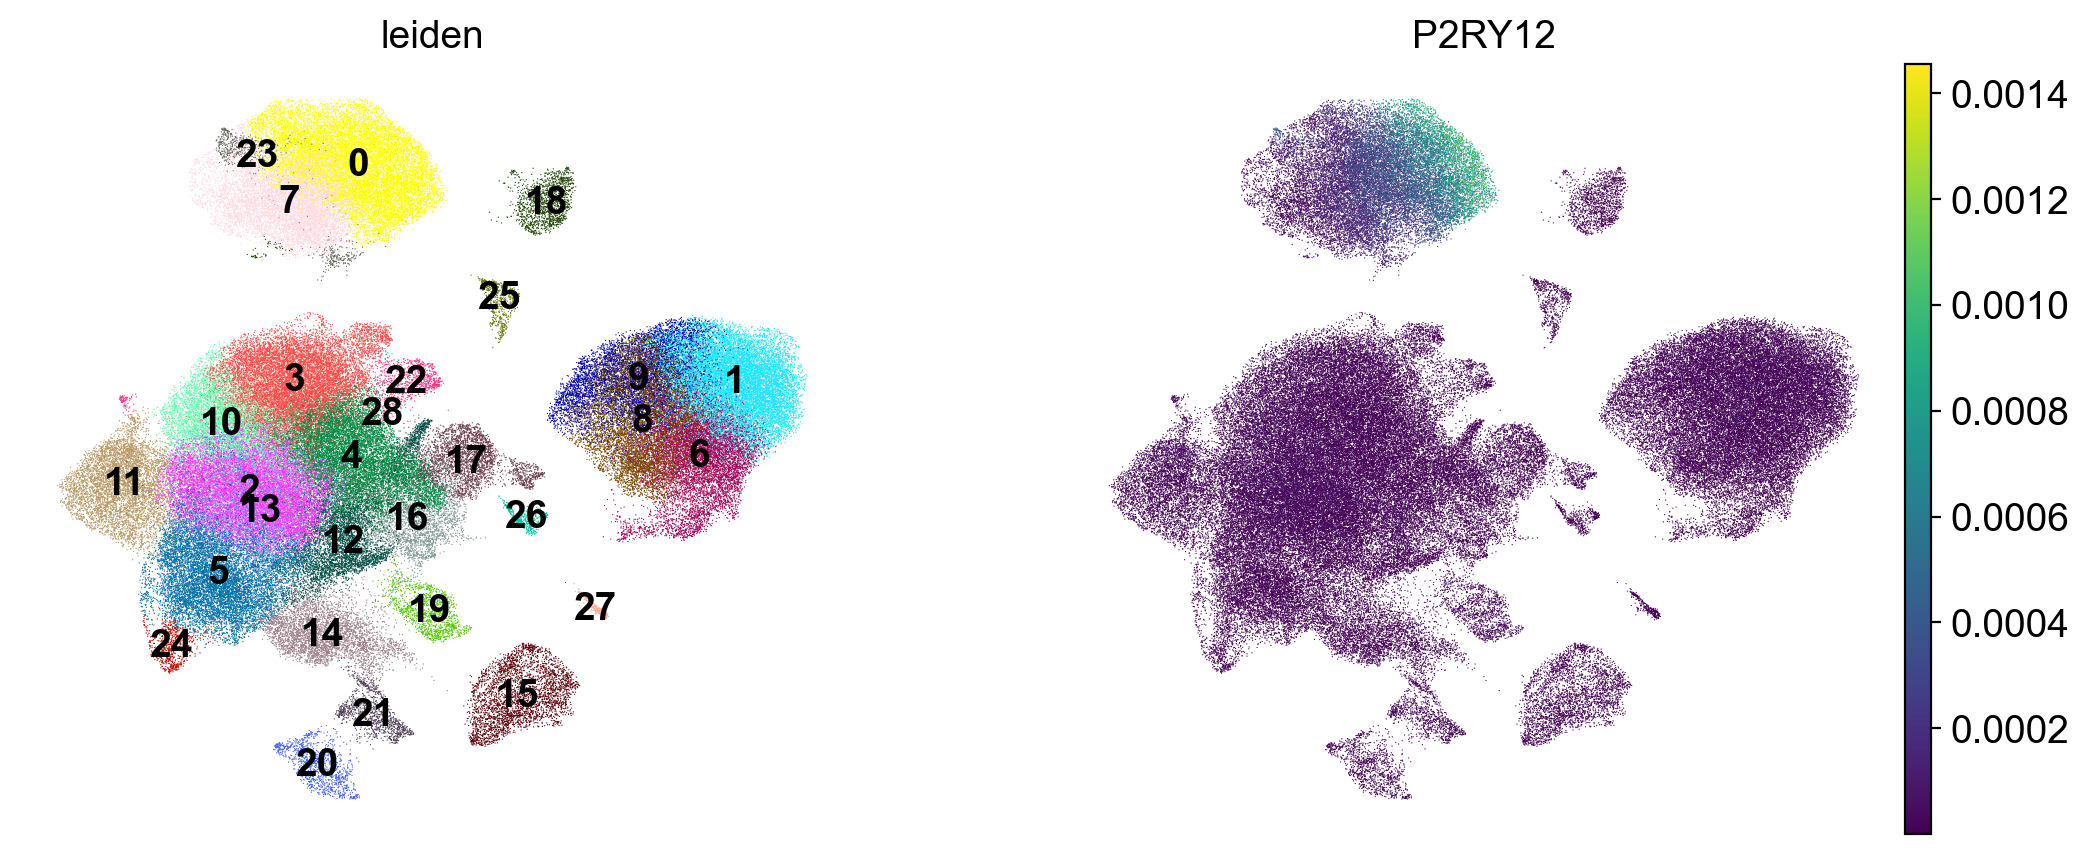

In [27]:
rcParams['figure.figsize'] = (5.3, 5)

sc.pl.umap(
    adata,
    color = ['leiden', 'P2RY12'],
    frameon = False,
    legend_loc = 'on data',
    layer = 'scvi_normalized',
)

# Save the integrated data and scVI model

In [28]:
# scvi_normalized layer를 sparse matrix로 저장하기 위한 발악
import numpy as np
count_non_zeros = np.count_nonzero(adata.layers['scvi_normalized'])
count_zeros = adata.layers['scvi_normalized'].size - count_non_zeros
print(count_non_zeros)
print(count_zeros)


4454472692
0


In [29]:
adata.write_h5ad(folder_path + "adata_scVI.h5ad")
model.save(folder_path + 'model/')  # trained model 저장
# running time: 3m 42s for 94 samples
# .h5ad file: 21GB